# Solving an Explosive Diffusion-Reaction System

_This demo is part of Spitfire, with [licensing and copyright info here.](https://github.com/sandialabs/Spitfire/blob/master/license.md)_


_Highlights_

- Using `odesolve` and SuperLU to solve 1D diffusion-reaction problems on a nonuniform grid
- Varying the diffusion coefficient to see ignition limits in a simplified chemical system

## Introduction

Diffusion-reaction (DR) dynamics are a fundamental aspect of many mathematical models of physical processes, especially in biology and combustion. In combustion, streams of fuel and air are brought into close contact by advective transport and must be mixed by diffusive processes before they can react and ignite. The coupling of transport processes and chemical reactions ultimately determine the structures of combusting flows from candle flames on the kitchen table to fireplaces and gigantic industrial burners. In many of these systems, scale separation arguments lead to practical models that handle the tight coupling of diffusion and reaction separately from slower transport processes. In biology, patterns in animal coats and nerve firings and many more phenomena are often mathematically represented with diffusion-reaction models.

In this demonstration we consider a one-dimensional system of coupled, nonlinear diffusion-reaction equations. Using $\phi_i$ to represent the concentration of a particular chemical species, each transport equation can be written as

$$
\frac{\partial\phi_i}{\partial t} = D\frac{\partial^2\phi_i}{\partial x^2} + \omega_i(\phi_1,\phi_2,\ldots),
$$

where $t$ is the time coordinate, $x$ is the spatial coordinate, $D$ is the diffusion coefficient, and $\omega_i$ is the net rate of production of species $i$ via chemical reactions, which may depend on any number of the chemical species. The system of equations is completed by initial conditions $\phi_i(0,x)=f_i(x)$ and boundary conditions, for which we use Dirichlet conditions based on the chosen initial condition, $\phi(t,x=0)=f_i(0)$ and $\phi(t,x=1)=f_i(1)$. Another interesting option is to introduce variation of a boundary value in time.


## Toy Problem with Ignition Dynamics

In this particular notebook, we write a general-purpose `DiffusionReaction` class that can solve any number of such equations. We use it to study a particular system involving four chemical species undergoing two reactions. These reactions are not physical - this is a 'toy' system designed to mimick behaviors of ignition chemistry of large hydrocarbons. In the first 'induction' reaction, species A and B react to form species C. This reaction is heavily favored towards consumption of A, as 3 molecules are required for each of B. A tetramolecular reaction such as this is not likely, but again, this is merely a toy problem.

$$
\text{(1) Induction reaction: } 3\mathrm{A} + \mathrm{B} \to \mathrm{C}
$$

The next reaction, which mimics chemical runaway characteristic of ignition, involves species B and C, which react to produce an additional molecule of C. This reaction yields explosive behavior as it accelerates itself until species B is exhausted.

$$
\text{(2) Ignition reaction: } \mathrm{B} + 3\mathrm{C} \to 4\mathrm{C}
$$

Supplementing A, B, and C is a fourth species D that is inert and used as a diluent/balance. Thus, given a homogeneous mixture of A, B, and D, reaction (1) will occur until enough C is produced to spark reaction (2) which eventually takes over as A is consumed and C is produced faster and faster. Our diffusion-reaction problem, however, will be a bit more interesting - we'll start with linear profiles of A and B, with A provided from the left side of the domain and B from the right side. In this configuration, reaction (1) starts on the left side where A is more prevalent, and then reaction (2) will spark on the left and follow a wave to the right into reactions with more of species B.

The governing equations for this problem are
$$
\frac{\partial\phi_A}{\partial t} = D\frac{\partial^2\phi_A}{\partial x^2} - 3r_1, \\
\frac{\partial\phi_B}{\partial t} = D\frac{\partial^2\phi_B}{\partial x^2} - r_1 - r_2, \\
\frac{\partial\phi_C}{\partial t} = D\frac{\partial^2\phi_C}{\partial x^2} + r_1 + r_2, \\
\frac{\partial\phi_D}{\partial t} = D\frac{\partial^2\phi_D}{\partial x^2}, \\
$$

where $r_1 = k_1 \phi_A^3 \phi_B$ and $r_2 = k_2 \phi_B \phi_C^3$ are the rates of reactions (1) and (2), respectively, with rate constants $k_j$.


## Solution Procedure

To solve this problem, we first discretize the spatial dimension with a standard nodal finite differencing scheme for grids with nonuniform spacing. This employs a three-point stencil and the equations are grouped so that the resultant Jacobian of the ODE system has a block-tridiagonal structure. Using `odesolve`'s default implicit Runge-Kutta solver (see prior demonstrations for more discussion) with adaptive time-stepping requires us to solve linear systems like the following.

$$
p
\Delta t
\left(
\begin{pmatrix}
\mathrm{0} \\
& \mathrm{K}_1 \\
& & \mathrm{K}_2 \\
& & & \ddots  \\
& & & & \mathrm{K}_{n-2} \\
& & & & & \mathrm{0}
\end{pmatrix}
+
\begin{pmatrix}
\mathrm{0} \\
b_1\mathrm{I} & d_1\mathrm{I} & p_1\mathrm{I} \\
& b_2\mathrm{I} & d_2\mathrm{I} & p_2\mathrm{I} \\
& & \ddots & \ddots & \ddots \\
& & & b_{n-2}\mathrm{I} & d_{n-2}\mathrm{I} & p_{n-2}\mathrm{I} \\
& & & & & \mathrm{0}
\end{pmatrix}
\right)
-
\begin{pmatrix}
\mathrm{I} \\
  & \mathrm{I} \\
& & \mathrm{I} \\
& & & \ddots & \ddots \\
& & & & \mathrm{I} & \\
& & & & & \mathrm{I}
\end{pmatrix},
$$

where the block-diagonal chemistry term is 
$$
[\mathrm{K}_i]_{jk} = \frac{\partial \omega_j}{\partial \phi_k},
$$
and the tridiagonal diffusion term is made up of stencil coefficients $b_i$, $d_i$, and $p_i$. In the case of a uniform grid, these would simply be the well-known coefficients $1/(\Delta x)^2$, $-2/(\Delta x)^2$, and $1/(\Delta x)^2$. Note that in the above the zeros on the first and last rows represent the boundary terms whose right-hand side functions are zero to preserve the Dirichlet BCs. A formulation that includes the boundary nodes is unnecessary here but can be more easily generalized to Neumann or Robin conditions.

In Spitfire's solvers for non-premixed flamelets, which possess a similar structure, a specialized solver is used for block-tridiagonal matrices with diagonal off-diagonal blocks. This solver is especially important for flamelets because the size of the blocks is often larger than the number of them (for instance, solving 170 equations on grids of 128 nodes). To keep things simple in this example, whose blocks are only 4x4 matrices, we employ SciPy sparse matrices and the SuperLU sparse linear solver.

With the `DiffusionReaction` class below, which is similar to the class defined in the previous advection-diffusion demonstration notebook, we define the `setup_superlu` to evaluate the Jacobian and use SuperLU for the factorization, and the `solve_superlu` methods to perform the back-substitution. As the back-substitution is significantly faster, it can be worthwhile to freeze the Jacobian and its factored form for several time steps - Spitfire does this automatically when you set the `linear_setup_rate` argument to a number greater than one. The `linear_setup_rate` is the largest number of time steps between calls to the linear setup method. By default it is one but in this problem it can be advantageous to increase it and let heuristics inform Jacobian evaluation.

A final subtlety in the code below is that the `DiffusionReaction` class itself does not know how to evaluate the right-hand side or Jacobian - these are specified externally for a given chemical mechanism.

In [1]:
import numpy as np
from scipy.sparse import csc_matrix, diags, block_diag, eye as speye
from scipy.sparse.linalg import splu as superlu_factor

class DiffusionReaction(object):
    def __init__(self,
                 initial_conditions,
                 diffusion_coefficient,
                 source_term,
                 source_term_jacobian,
                 grid_points=65,
                 grid_cluster_intensity=2.,
                 grid_cluster_point=0.8):

        # make the nonuniform grid in the x-direction
        self._x = np.linspace(0., 1., grid_points)
        xo = 1.0 / (2.0 * grid_cluster_intensity) * np.log(
            (1. + (np.exp(grid_cluster_intensity) - 1.) * grid_cluster_point) / (
                1. + (np.exp(-grid_cluster_intensity) - 1.) * grid_cluster_point))
        a = np.sinh(grid_cluster_intensity * xo)
        self._x = grid_cluster_point / a * (np.sinh(grid_cluster_intensity * (self._x - xo)) + a)
        self._x[-1] = 1.
        self._dx = self._x[1:] - self._x[:-1]
        self._nx = self._x.size
        
        self._neq = len(initial_conditions)
        self._ndof = self._neq * self._nx
        
        self._d = np.zeros_like(self._x) + diffusion_coefficient
        
        self._initial_state = np.zeros(self._ndof)
        for offset, initial_condition in enumerate(initial_conditions):
            if callable(initial_condition):
                self._initial_state[offset::self._neq] = initial_condition(self._x)
            else:
                self._initial_state[offset::self._neq] = initial_condition

        self._source_term = source_term
        self._source_term_jacobian = source_term_jacobian

        # creating a sparse matrix for the diffusion operator, most of this is just dealing with the nonuniform grid
        self._lhs_inverse_operator = None
        self._I = csc_matrix(speye(self._ndof))
        dxt = self._dx[:-1] + self._dx[1:]
        self._major_coeffs = - 2. * self._d[1:-1] / (self._dx[:-1] * self._dx[1:])
        self._sub_coeffs = 2. * self._d[1:-1] / (dxt * self._dx[:-1])
        self._sup_coeffs = 2. * self._d[1:-1] / (dxt * self._dx[1:])
        majdiag = np.tile(self._major_coeffs, (self._neq, 1)).T.ravel()
        supdiag = np.tile(self._sup_coeffs, (self._neq, 1)).T.ravel()
        subdiag = np.tile(self._sub_coeffs, (self._neq, 1)).T.ravel()
        self._diffop = csc_matrix(diags([np.hstack([np.zeros(self._neq), majdiag, np.zeros(self._neq)]), 
                                         np.hstack([np.zeros(self._neq), supdiag]), 
                                         np.hstack([subdiag, np.zeros(self._neq)])], 
                                        [0, self._neq, -self._neq]))

    @property
    def initial_state(self):
        return self._initial_state
    
    @property
    def x(self):
        return self._x
    
    def right_hand_side(self, t, state):
        rhs = self._source_term(t, state) + self._diffop.dot(state)
        return rhs

    def setup_superlu(self, t, state, prefactor):
        jac = self._source_term_jacobian(t, state) + self._diffop
        self._lhs_inverse_operator = superlu_factor(prefactor * jac - self._I)

    def solve_superlu(self, residual):
        return self._lhs_inverse_operator.solve(residual), 1, True

### Source Term Expressions

These functions evaluate the reaction rate and sensitivities for $r_1 = k_1 \phi_A^3 \phi_B$ and $r_2 = k_2 \phi_B \phi_C^3$, summing the terms into the chemical contribution to the right-hand side according to reaction stoichiometry.

In [2]:
def source_term(t, c, k_1, k_2):
    neq = 4
    rhs = np.zeros_like(c)
    c_a = c[neq:-neq:neq]
    c_b = c[neq+1:-neq:neq]
    c_c = c[neq+2:-neq:neq]
    c_d = c[neq+3:-neq:neq]
    q_1 = k_1 * c_a * c_a * c_a * c_b
    q_2 = k_2 * c_b * c_c * c_c * c_c
    rhs[4:-4:4] = -3. * q_1
    rhs[5:-4:4] = -q_1 - q_2
    rhs[6:-4:4] =  q_1 + q_2
    rhs[7:-4:4] = 0.
    return rhs

def source_term_jacobian(t, c, k_1, k_2):
    neq = 4
    c_a = c[neq:-neq:neq]
    c_b = c[neq+1:-neq:neq]
    c_c = c[neq+2:-neq:neq]
    c_d = c[neq+3:-neq:neq]
    dq1_ca = k_1 * 3. * c_a * c_a * c_b
    dq1_cb = k_1 * c_a * c_a * c_a
    dq1_cc = 0.
    dq1_cd = 0.
    dq2_ca = 0.
    dq2_cb = k_2 * c_c * c_c * c_c
    dq2_cc = 3. * k_2 * c_b * c_c * c_c
    dq2_cd = 0.
    
    karray = np.zeros((c.size // 4, 4, 4))
     
    karray[1:-1, 0, 0] = -3. * dq1_ca
    karray[1:-1, 0, 1] = -3. * dq1_cb
    karray[1:-1, 0, 2] =  dq1_cc
    karray[1:-1, 0, 3] =  dq1_cd
    
    karray[1:-1, 1, 0] = -dq1_ca - dq2_ca
    karray[1:-1, 1, 1] = -dq1_cb - dq2_cb
    karray[1:-1, 1, 2] = -dq1_cc - dq2_cc
    karray[1:-1, 1, 3] = -dq1_cc - dq2_cc
    
    karray[1:-1, 2, 0] = dq1_ca + dq2_ca
    karray[1:-1, 2, 1] = dq1_cb + dq2_cb
    karray[1:-1, 2, 2] = dq1_cc + dq2_cc
    karray[1:-1, 2, 3] = dq1_cd + dq2_cd
    
    karray[1:-1, 3, 0] = 0.
    karray[1:-1, 3, 1] = 0.
    karray[1:-1, 3, 2] = 0.
    karray[1:-1, 3, 3] = 0.
    
    kjac = block_diag(karray, format='csc')
    
    return kjac

## Ignition Dynamics

Now we're ready to solve the system with `odesolve`. The reaction rate constants are specified below and the `src` and `jac` methods alias the source terms and sensitivities above. This case is run until the steady state is identified (small residual norm) and the state at every time step is saved. The default PI controller used by Spitfire has too high of a target error to run this case, so we specify a lower value below. Finally, the `show_solver_stats_in_situ` keyword turns on the extra logger output of nonlinear and linear convergence rates along with the average number of steps taken per Jacobian evaluation and factorization.

In [3]:
from spitfire import PIController, odesolve

k_1 = 0.5
k_2 = 2.e2

src = lambda t, y: source_term(t, y, k_1, k_2)
jac = lambda t, y: source_term_jacobian(t, y, k_1, k_2)

ics = [lambda x: 0.8 * (1. - x), 
       lambda x: 0.7 * x,
       0.,
       lambda x: 0.3 * x]

D = 0.01
model = DiffusionReaction(ics, D, src, jac, grid_points=256)

t, q = odesolve(model.right_hand_side,
                model.initial_state,
                stop_at_steady=True,
                save_each_step=True,
                linear_setup=model.setup_superlu,
                linear_solve=model.solve_superlu,
                step_size=PIController(target_error=1.e-8),
                linear_setup_rate=20,
                verbose=True,
                log_rate=100,
                show_solver_stats_in_situ=True)


 2024-03-15 14:42 : Spitfire running case with method: Kennedy/Carpenter ESDIRK64

|number of  | simulation | time step  | nlin. iter | lin. iter  | steps      | diff. eqn. | total cpu  | cput per |
|time steps | time (s)   | size (s)   | per step   | per nlin.  | per Jac.   | |residual| | time (s)   | step (ms)|
------------------------------------------------------------------------------------------------------------------|
| 100       | 1.41e+01   | 1.86e-02   | 15.98      | 1.00       | 1.10       | 6.89e-01   | 6.31e-01   | 6.31e+00 |
| 200       | 1.49e+01   | 6.46e-03   | 24.66      | 1.00       | 2.08       | 1.67e+00   | 1.12e+00   | 5.60e+00 |

Integration successfully completed!

Statistics:
- number of time steps : 285
- final simulation time: 67.50370308364087
- smallest time step   : 0.001
- average time step    : 0.23685509853909079
- largest time step    : 4.6036175764439715

  CPU time
- total    (s) : 1.626761e+00
- per step (ms): 5.707932e+00

  Nonlinear iteration

### Results

The slider animation below shows the concentration profiles of each species in addition to the normalized rate of the chemical production of species C. As discussed above, the induction reaction produces C early on in A-rich mixtures around $x=0.2$ followed by a wave of C production up the $x$-coordinate into the B-rich right side.

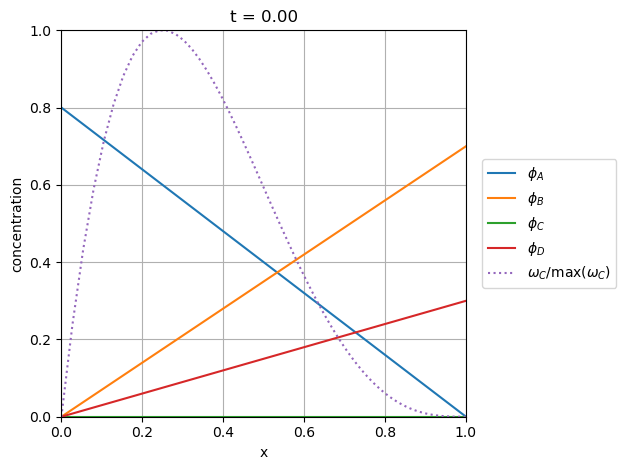

In [9]:
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

lA, = plt.plot(model.x, q[0, 0::4], label='$\phi_A$')
lB, = plt.plot(model.x, q[0, 1::4], label='$\phi_B$')
lC, = plt.plot(model.x, q[0, 2::4], label='$\phi_C$')
lD, = plt.plot(model.x, q[0, 3::4], label='$\phi_D$')
rC = source_term(0, q[0, :].ravel(), k_1, k_2)[2::4]
lR, = plt.plot(model.x, rC / np.max(rC), ':', label='$\omega_C/\max(\omega_C)$')
plt.xlim([model.x[0], model.x[-1]])
plt.ylim([0., 1.])
plt.grid()
plt.xlabel('x')
plt.ylabel('concentration')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.title(f't = {t[0]:.2f}')
plt.tight_layout()

def f(it):
    plt.title(f't = {t[it]:.2f}')
    lA.set_ydata(q[it, 0::4])
    lB.set_ydata(q[it, 1::4])
    lC.set_ydata(q[it, 2::4])
    lD.set_ydata(q[it, 3::4])
    rC = source_term(0, q[it, :].ravel(), k_1, k_2)[2::4]
    lR.set_ydata(rC / np.max(rC))

# interact(f, it=widgets.IntSlider(min=0, max=t.size-1, step=1, value=0));

The following contour plot shows the concentration of C in the $(x,t)$ plane in addition to the locations of the maximum reaction rates and maximum production rate of C as they vary through time. This further confirms that the induction reaction dominates C production early on and that it shifts to follow the ignition reaction later.

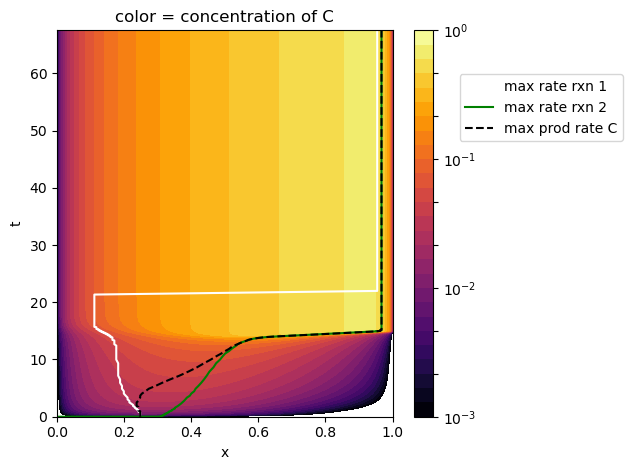

In [5]:
from matplotlib.colors import LogNorm

C = q[:, 2::4]
xC = np.zeros_like(t)
x1 = np.zeros_like(t)
x2 = np.zeros_like(t)
for i in range(t.size):
    rateC = source_term(0, q[i, :].ravel(), k_1, k_2)[2::4]
    c_a = q[i, :].ravel()[0::4]
    c_b = q[i, :].ravel()[1::4]
    c_c = q[i, :].ravel()[2::4]
    q_1 = k_1 * c_a * c_a * c_a * c_b
    q_2 = k_2 * c_b * c_c * c_c * c_c
    xC[i] = model.x[np.argmax(rateC)]
    x1[i] = model.x[np.argmax(q_1)]
    x2[i] = model.x[np.argmax(q_2)]

plt.contourf(model.x, t, C+1e-16, np.logspace(-3, 0, 28), cmap='inferno', norm=LogNorm(1.e-3, 1))
plt.colorbar()
plt.plot(x1, t, 'w-', label='max rate rxn 1')
plt.plot(x2, t, 'g-', label='max rate rxn 2')
plt.plot(xC, t, 'k--', label='max prod rate C')
plt.title('color = concentration of C')
plt.xlabel('x')
plt.ylabel('t')
plt.legend(bbox_to_anchor=(1.2,0.8), loc="center left", borderaxespad=0)
plt.tight_layout()
plt.show()

## Ignition Limits

Now we solve the problem across a range of diffusion coefficients to see its impact on the ignition dynamics. In order to simpify animating the range of solutions we specify the list of output times for each solution.

In [6]:
times = np.hstack((np.linspace(0, 40, 101), 60., 80.))
sol_dict = dict()

for D in [0.005, 0.01, 0.015, 0.02, 0.025, 0.03]:
    model = DiffusionReaction(ics, D, src, jac)
    q = odesolve(model.right_hand_side,
                 model.initial_state,
                 times,
                 linear_setup=model.setup_superlu,
                 linear_solve=model.solve_superlu,
                 step_size=PIController(target_error=1.e-8),
                 linear_setup_rate=20,
                 verbose=False,
                 log_rate=100,
                 show_solver_stats_in_situ=True)
    print(f'completed D = {D:.3f}')
    sol_dict[D] = np.copy(q)

completed D = 0.005
completed D = 0.010
completed D = 0.015
completed D = 0.020
completed D = 0.025
completed D = 0.030


The animation below shows that at $D=0.025$ and $D=0.03$ the system fails to ignite as a critical concentration of species C is unable to develop, being diffused away to form an equilibrium below the value needed for reaction (2) to accelerate and ignite. The reason the output times above are extended to 80 seconds is simply to ensure that these systems are indeed not igniting.

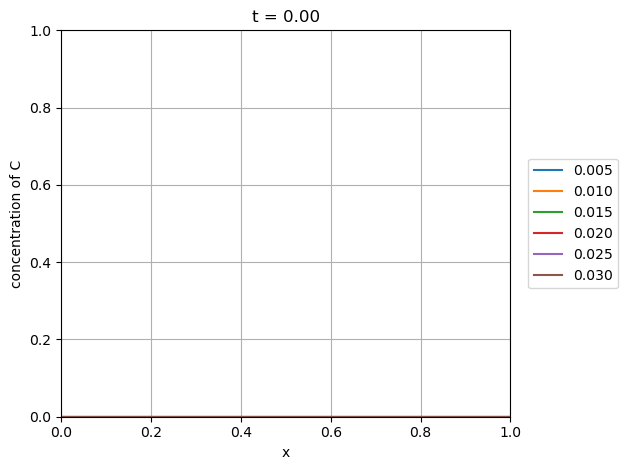

In [10]:
l_dict = dict()
for D in sol_dict:
    l_dict[D], = plt.plot(model.x, sol_dict[D][0, 2::4], label=f'{D:.3f}')
plt.xlim([model.x[0], model.x[-1]])
plt.ylim([0., 1.])
plt.grid()
plt.xlabel('x')
plt.ylabel('concentration of C')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.title(f't = {times[0]:.2f}')
plt.tight_layout()

def f(it):
    plt.title(f't = {times[it]:.2f}')
    for D in sol_dict:
        l_dict[D].set_ydata(sol_dict[D][it, 2::4])

# interact(f, it=widgets.IntSlider(min=0, max=times.size-1, step=1, value=0));

Another way to visualize ignition is to show the time history of the mean value of $\phi_C$, which is shown below along with its time derivative to demonstrate the effect of the diffusion coefficient on the ignition delay.

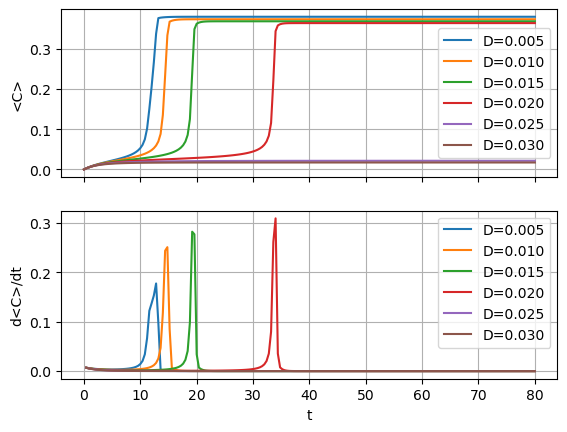

In [8]:
fig, axarray = plt.subplots(2, 1, sharex=True)

for D in sol_dict:
    qCmean = np.mean(sol_dict[D][:, 2::4], axis=1)
    dt = times[1:] - times[:-1]
    axarray[0].plot(times, qCmean, label=f'D={D:.3f}')
    axarray[1].plot(times[1:], (qCmean[1:] - qCmean[:-1]) / dt, '-', label=f'D={D:.3f}')
axarray[1].set_xlabel('t')
axarray[0].set_ylabel('<C>')
axarray[1].set_ylabel('d<C>/dt')
axarray[0].legend(loc='best')
axarray[1].legend(loc='best')
axarray[0].grid()
axarray[1].grid()
plt.show()

## Conclusions

We've used Spitfire's `odesolve` method along with SciPy sparse matrix operators and SuperLU to study a four-species diffusion-reaction system that mimicks ignition chemistry of hydrocarbon-air mixtures.